In [1]:
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
import os



## Tasks for Alex Marzban

- Set up development environment and dependencies (Python, OpenCV, NumPy).
- Implement video I/O and frame preprocessing pipeline (grayscale conversion, window cropping, cosine window).
- Code MOSSE filter initialization (training on first frame) and implement online filter update (Equations 10–12).
- Test preprocessing functions and filter update logic.
- Draft the Motivation, Approach and Implementation Details sections of the project report.

## Tasks for Ayush Sharma:

- Develop bounding-box overlay and live visualization (drawing tracked box, PSR display).
- Integrate occlusion detection using PSR thresholds and implement scale/illumination adaptation.
- Profile and optimize the code for real-time performance (FFT acceleration, vectorization, target ≥30 FPS).
- Collect performance data and generate plots.
- Draft the Real-Time Performance and Results subsections of the report.

## Implementation

#### Setup ROI and loading functions

In [2]:
def select_roi_from_video(video_path, save_roi_file=None):
    #Selects roi and saves to a txt file if specified file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video file.")
        return None
    ret, frame = cap.read()
    if not ret:
        print("Error: Could not read the first frame of the video.")
        cap.release()
        return None
    roi = cv2.selectROI("Select ROI", frame, fromCenter=False, showCrosshair=True)
    cv2.destroyWindow("Select ROI")
    if save_roi_file:
        with open(save_roi_file, "w") as f:
            f.write(",".join(str(v) for v in roi))
        print(f"ROI saved to {save_roi_file}")
    cap.release()
    return roi

def load_roi(roi_file):
    with open(roi_file, "r") as f:
        roi_str = f.read().strip()
    return tuple(map(int, roi_str.split(",")))

In [3]:
def create_cosine_window(width, height):
    #Using Hanning window for both dimensions and compute the outer product
    hann_1d_w = np.hanning(width)
    hann_1d_h = np.hanning(height)
    cosine_window = np.outer(hann_1d_h, hann_1d_w)
    return cosine_window.astype(np.float32)

#### Important Functions for MOSSE

In [4]:
def create_gaussian_response(size, sigma):
    """Create desired output (Gaussian peak), and FFT it"""
    w, h = size
    x = np.arange(w) - w/2
    y = np.arange(h) - h/2
    xv, yv = np.meshgrid(x, y)
    gauss = np.exp(-0.5 * (xv**2 + yv**2) / sigma**2)
    return np.fft.fft2(gauss.astype(np.float32))


def preprocess(img):
    """Preprocessing: log, normalize, and window"""
    img = np.log(img + 1.0)
    img = (img - img.mean()) / (img.std() + 1e-5)
    return img * window

def random_warp(img):
    """Apply a small random warp to generate synthetic training samples"""
    h, w = img.shape
    # Random rotation, scale, translation
    ang = np.random.uniform(-0.1, 0.1)  # radians
    sc = np.random.uniform(0.9, 1.1)
    c, s = np.cos(ang)*sc, np.sin(ang)*sc
    M = np.array([[ c, -s, 0],
                  [ s,  c, 0]], dtype=np.float32)
    # random shifts
    M[0,2] = np.random.uniform(-0.1*w, 0.1*w)
    M[1,2] = np.random.uniform(-0.1*h, 0.1*h)
    return cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_REFLECT)

def init_filter(frame):
    """Initialize Ai and Bi by generating warped samples from the first ROI"""
    global Ai, Bi
    x, y = int(pos[0] - size[0]/2), int(pos[1] - size[1]/2)
    x, y = max(0,x), max(0,y)
    patch = frame[y:y+int(size[1]), x:x+int(size[0])]
    patch = cv2.resize(patch, (int(size[0]), int(size[1])))

    for _ in range(num_warps):
        warped = random_warp(patch)
        X = preprocess(warped)
        F = np.fft.fft2(X)
        Ai += G * np.conj(F)
        Bi += F * np.conj(F)

def psr(resp):
    """Compute Peak-to-Sidelobe Ratio"""
    resp_real = resp.real
    h, w = resp_real.shape
    # find peak
    cy, cx = np.unravel_index(np.argmax(resp_real), resp_real.shape)
    peak = resp_real[cy, cx]
    # mask out a small window around the peak
    sidelobe = resp_real.copy()
    r = 5  # exclusion radius
    y1, y2 = max(0, cy-r), min(h, cy+r+1)
    x1, x2 = max(0, cx-r), min(w, cx+r+1)
    sidelobe[y1:y2, x1:x2] = 0
    mean = sidelobe.mean()
    std = sidelobe.std()
    return (peak - mean) / (std + 1e-5)



In [5]:
def update(frame):
    """
    Track object in new frame.
    Returns: (x, y, w, h) of updated bounding box, PSR value
    """
    global Ai, Bi, learning_rate, G, pos, size
    w, h = int(size[0]), int(size[1])
    # 1) extract patch at current position (with border-reflect)
    patch = cv2.getRectSubPix(frame, (w, h), pos)
    X = preprocess(patch)
    F = np.fft.fft2(X)

    # 2) form filter and correlate
    H = Ai / (Bi + 1e-5)
    resp = np.fft.ifft2(H * F)
    resp_real = resp.real

    # 3) find peak & displacement
    cy, cx = np.unravel_index(np.argmax(resp_real), resp_real.shape)
    dy, dx = cy - h//2, cx - w//2
    new_pos = (pos[0] + dx, pos[1] + dy)

    # 4) compute PSR
    psr_value = psr(resp)
    if psr_value > psr_threshold:
        # commit to new position
        pos = new_pos

        # 5) re-extract patch at updated pos for learning
        patch2 = cv2.getRectSubPix(frame, (w, h), pos)
        X2 = preprocess(patch2)
        F2 = np.fft.fft2(X2)

        # 6) exponential moving average update
        Ai = (1 - learning_rate) * Ai + \
                    learning_rate * (G * np.conj(F2))
        Bi = (1 - learning_rate) * Bi + \
                    learning_rate * (F2 * np.conj(F2))

    # return integer bbox and PSR
    x_new = int(round(pos[0] - w/2))
    y_new = int(round(pos[1] - h/2))
    return (x_new, y_new, w, h), psr_value

#### Initialize variables

In [80]:
video_path = 'Media/ballMoving.mov'
select_roi_from_video(video_path, save_roi_file="roi.txt")
x, y, w, h  = roi = load_roi("roi.txt")
print("Selected ROI:", roi)

learning_rate = 0.125
num_warps = 8
psr_threshold = 8.0
pos = (x + w/2, y + h/2)       # center position
size = (w, h)                  # (width, height)
window = create_cosine_window(w, h)
G = create_gaussian_response((int(w), int(h)), sigma=2.0)

Ai = np.zeros_like(G, dtype=np.complex64)
Bi = np.zeros_like(G, dtype=np.complex64)

ROI saved to roi.txt
Selected ROI: (21, 378, 253, 271)


In [7]:
def track(path, type="video"):
    cap = cv2.VideoCapture(path)

    ret, frame = cap.read()
    if not ret:
        print("Failed to open video")
        sys.exit(1)
    
    # Prepare first frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)
    init_filter(gray)

    # Lists for performance data
    fps_list = []
    psr_list = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)

        # Measure start time
        start_time = time.perf_counter()

        (x1, y1, w1, h1), psr_value = update(gray)

         # Measure end time
        end_time = time.perf_counter()

        # Calculate elapsed time
        elapsed = end_time - start_time
        fps = 1.0 / elapsed if elapsed > 0 else 0
        fps_list.append(fps)
        psr_list.append(psr_value)

        # Draw bounding box and PSR
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)

        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, f"PSR: {psr_value:.2f}", (10, 85),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        cv2.imshow("MOSSE Tracker", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

    # Generate plots
    plt.figure()
    plt.plot(fps_list)
    plt.title("Real-Time Performance (FPS over Frames)")
    plt.xlabel("Frame Index")
    plt.ylabel("FPS")
    plt.show()

    plt.figure()
    plt.plot(psr_list)
    plt.title("Tracking Confidence (PSR over Frames)")
    plt.xlabel("Frame Index")
    plt.ylabel("PSR")
    plt.show()

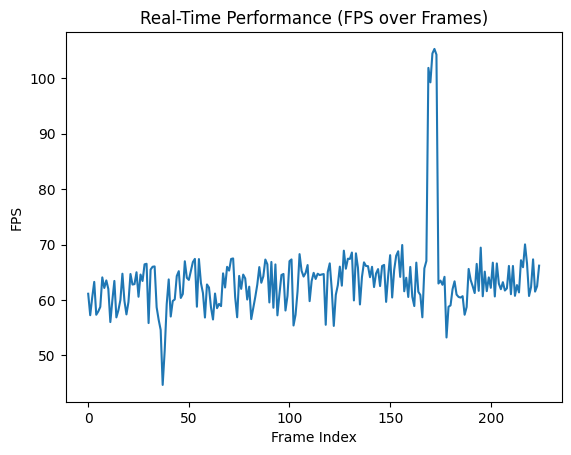

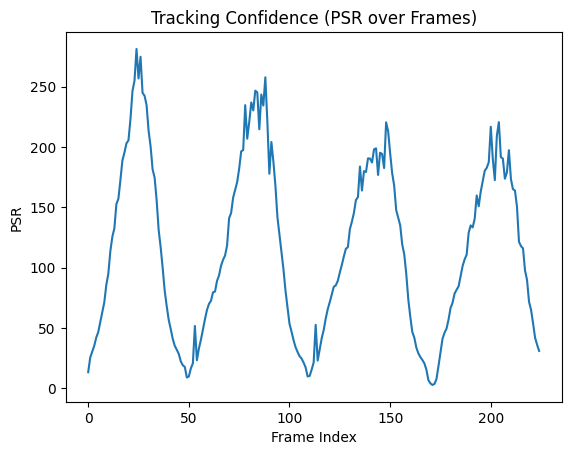

In [81]:


track(video_path, type="video")

## Evaluation of Algorithm

In [13]:
def track_eval(path, type="video"):
    global Ai, Bi, learning_rate, G, pos, size, x, y, w, h, window, psr_threshold, learning_rate, num_warps

    if type != "video":
        frame_dir = os.path.join(video_dir, 'img')
        roi_file = os.path.join(video_dir, 'groundtruth_rect.txt')
        with open(roi_file, "r") as f:
            roi_str = f.readline()
        roi = tuple(map(int, roi_str.split(",")))
        print("Ground truth:", roi)
    else:
        # Select ROI from video and save to file
        roi = select_roi_from_video(path, save_roi_file="roi.txt")
        if roi is None:
            print("Failed to select ROI")
            return
        print("Selected ROI:", roi)

    # ground truth for first frame
    x, y, w, h  = roi


    # re-Initialize global variables for this specific video
    
    pos = (x + w/2, y + h/2)       # center position
    size = (w, h)                  # (width, height)
    window = create_cosine_window(w, h)
    G = create_gaussian_response((int(w), int(h)), sigma=2.0)

    Ai = np.zeros_like(G, dtype=np.complex64)
    Bi = np.zeros_like(G, dtype=np.complex64)


    # Load all frames from the directory
    if type != "video":
        frame_files = sorted(os.listdir(frame_dir))
        frames = []
        for frame in frame_files:
            image_path = os.path.join(frame_dir, frame)
            image = cv2.imread(image_path)
            frames.append(image)
        frame = frames[0]
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.imshow('frame',frame)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    # Else open video
    else:
        cap = cv2.VideoCapture(path)

        ret, frame = cap.read()
        if not ret:
            print("Failed to open video")
            sys.exit(1)
    
    # Prepare first frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)
    init_filter(gray)

    # Lists for performance data
    fps_list = []
    psr_list = []
    ground_truth_list = []
    roi_list = []
    iou_list = []

    # Open ground truth file
    if type != "video":
        f = open(roi_file, "r")

    while True:

        if type != "video":
            # Read next frame from image list
            if len(frames) == 0:
                break
            frame = frames.pop(0)

            # read ground truth from file
            roi_str = f.readline()
            ground_truth = tuple(map(int, roi_str.split(",")))
            
        else:
            # Read next frame from video
            ret, frame = cap.read()
            if not ret:
                break

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32)

        # Measure start time
        start_time = time.perf_counter()

        (x1, y1, w1, h1), psr_value = update(gray)


         # Measure end time
        end_time = time.perf_counter()

        if type != "video":
            # Save tracked roi for evaluation
            roi = (x1, y1, w1, h1)

            # calculate iou
            iou_list.append(calculate_iou(ground_truth, roi))
            

        # Calculate elapsed time
        elapsed = end_time - start_time
        fps = 1.0 / elapsed if elapsed > 0 else 0
        fps_list.append(fps)
        psr_list.append(psr_value)

        # Draw ground truth box
        if type != "video":
            x_g, y_g, w_g, h_g = ground_truth
            cv2.rectangle(frame, (x_g, y_g), (x_g + w_g, y_g + h_g), (0, 0, 255), 2)


        # Draw bounding box and PSR
        cv2.rectangle(frame, (x1, y1), (x1 + w1, y1 + h1), (0, 255, 0), 2)

        cv2.putText(frame, f"FPS: {fps:.2f}", (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)
        cv2.putText(frame, f"PSR: {psr_value:.2f}", (10, 85),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 0), 2)

        cv2.imshow("MOSSE Tracker", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    if type == "video":
        cap.release()
    cv2.destroyAllWindows()

    # Generate plots
    plt.figure()
    plt.plot(fps_list)
    plt.title("Real-Time Performance (FPS over Frames)")
    plt.xlabel("Frame Index")
    plt.ylabel("FPS")
    plt.show()

    plt.figure()
    plt.plot(psr_list)
    plt.title("Tracking Confidence (PSR over Frames)")
    plt.xlabel("Frame Index")
    plt.ylabel("PSR")
    plt.show()
    
    


    if type != "video":
        plt.figure()
        plt.plot(iou_list)
        plt.title("Intersection over Union (IoU over Frames)")
        plt.xlabel("Frame Index")
        plt.ylabel("IoU")
        plt.show()



    if type != "video":
        f.close()


    # calculate % of frames tracked
    tracked_frames_iou = sum(1 for iou in iou_list if iou > 0.5)
    total_frames_iou = len(iou_list)
    tracking_percentage_iou = (tracked_frames_iou / total_frames_iou) * 100

    tracked_frames_psr = sum(1 for psr in psr_list if psr > psr_threshold)
    total_frames_psr = len(psr_list)
    tracking_percentage_psr = (tracked_frames_psr / total_frames_psr) * 100

    print("Tracking percentage (IoU): ", tracking_percentage_iou)
    print("Tracking percentage (PSR): ", tracking_percentage_psr)

    return ground_truth_list, roi_list

In [15]:
# Calculate IoU
def calculate_iou(ground_truth, roi):
    x1 = max(ground_truth[0], roi[0])
    y1 = max(ground_truth[1], roi[1])
    x2 = min(ground_truth[0] + ground_truth[2], roi[0] + roi[2])
    y2 = min(ground_truth[1] + ground_truth[3], roi[1] + roi[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    ground_truth_area = ground_truth[2] * ground_truth[3]
    roi_area = roi[2] * roi[3]

    union_area = ground_truth_area + roi_area - intersection_area
    iou = intersection_area / union_area if union_area > 0 else 0
    return iou

## Evaluation Video 1: BlurCar3

Ground truth: (228, 236, 80, 64)


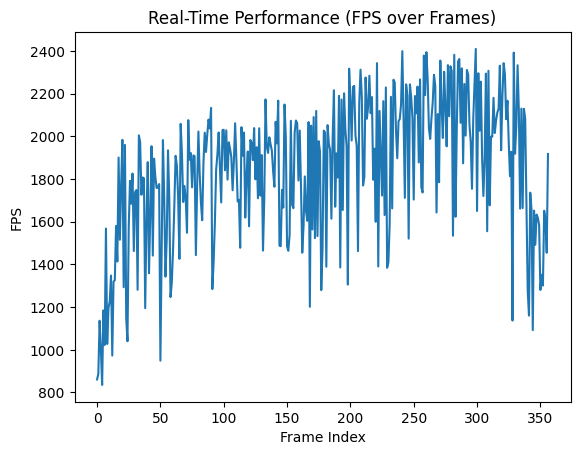

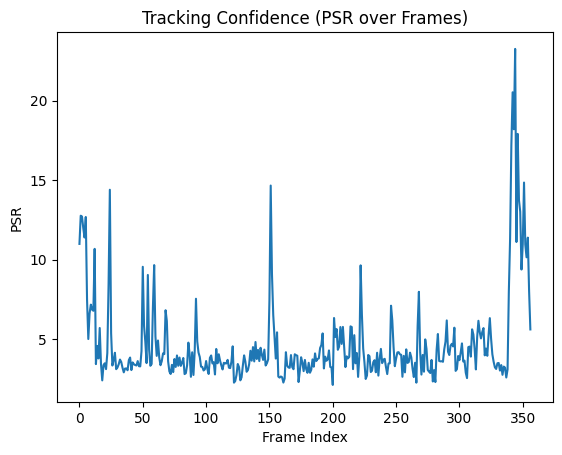

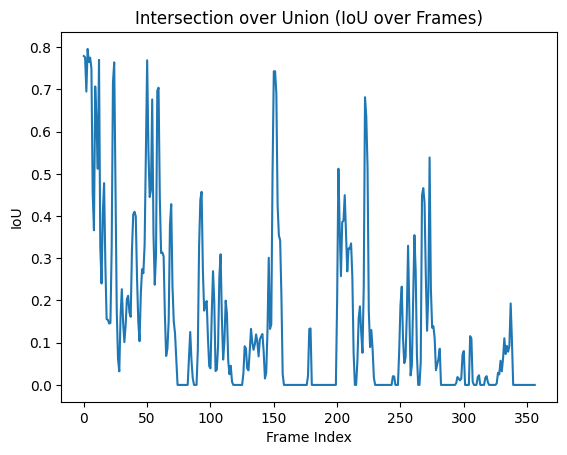

Tracking percentage (IoU):  7.8431372549019605
Tracking percentage (PSR):  10.92436974789916


In [85]:
videos_dir = 'Media\\OTB'
video_1 = 'BlurCar3'
video_dir = os.path.join(videos_dir, video_1)
frame_dir = os.path.join(video_dir, 'img')
frame_files = sorted(os.listdir(frame_dir))
frames = []
for frame in frame_files:
    image_path = os.path.join(frame_dir, frame)
    image = cv2.imread(image_path)
    frames.append(image)


'''
for frame in frames:
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
'''

'''
roi_file = os.path.join(video_dir, 'groundtruth_rect.txt')
with open(roi_file, "r") as f:
    roi_str = f.readline()
roi = tuple(map(int, roi_str.split("\t")))
print("Selected ROI:", roi)
'''
learning_rate = 0.125
num_warps = 8
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")






Ground truth: (228, 236, 80, 64)


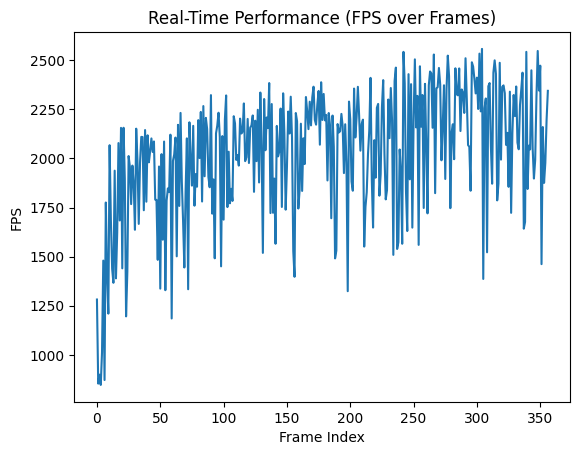

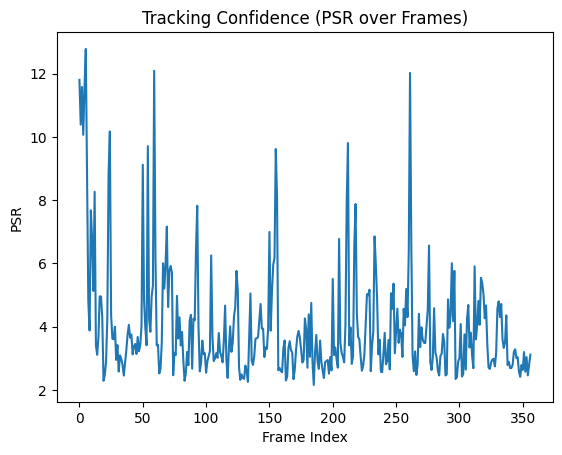

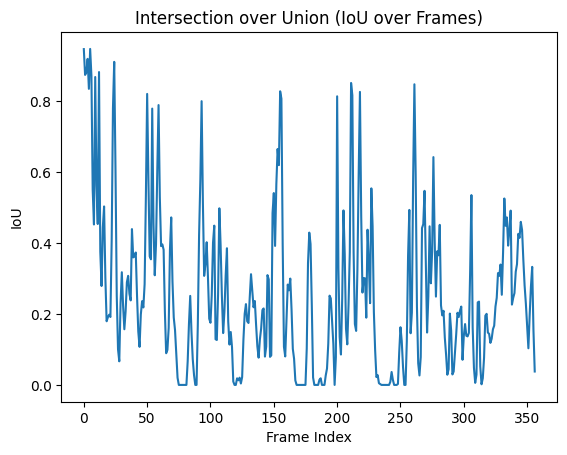

Tracking percentage (IoU):  12.324929971988796
Tracking percentage (PSR):  6.162464985994398


In [70]:

# Evaluate the same video different parameters
learning_rate = 0.1
num_warps = 16
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")


## Evaluation Video 2: Fish

Ground truth: (134, 55, 60, 88)


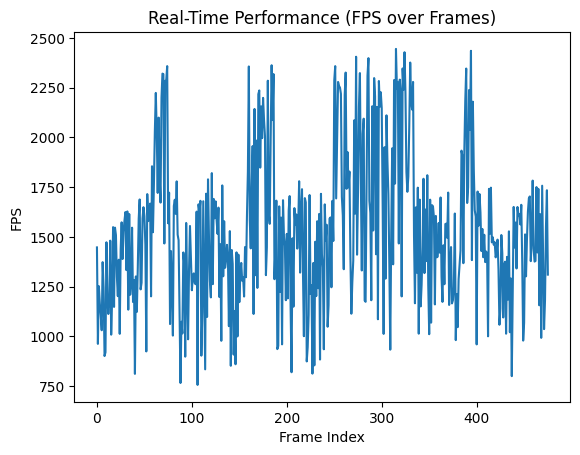

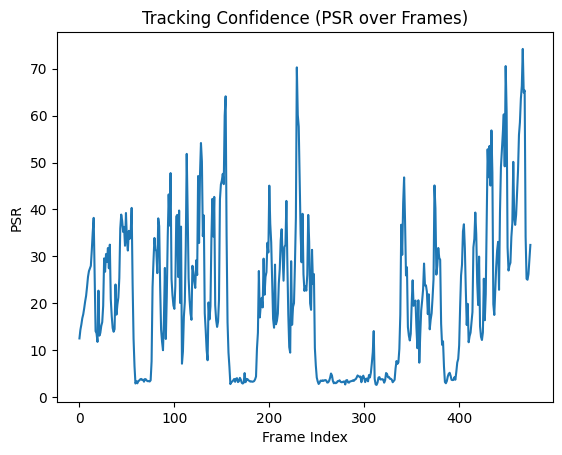

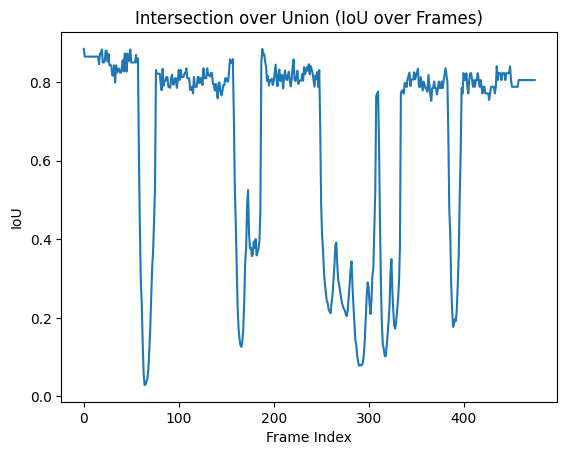

Tracking percentage (IoU):  72.26890756302521
Tracking percentage (PSR):  69.9579831932773


In [86]:
videos_dir = 'Media\\OTB'
video_1 = 'Fish'
video_dir = os.path.join(videos_dir, video_1)
frame_dir = os.path.join(video_dir, 'img')
frame_files = sorted(os.listdir(frame_dir))
frames = []
for frame in frame_files:
    image_path = os.path.join(frame_dir, frame)
    image = cv2.imread(image_path)
    frames.append(image)


'''
for frame in frames:
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()


roi_file = os.path.join(video_dir, 'groundtruth_rect.txt')
with open(roi_file, "r") as f:
    roi_str = f.readline()
roi = tuple(map(int, roi_str.split("\t")))
print("Selected ROI:", roi)
'''


learning_rate = 0.125
num_warps = 8
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")


Ground truth: (134, 55, 60, 88)


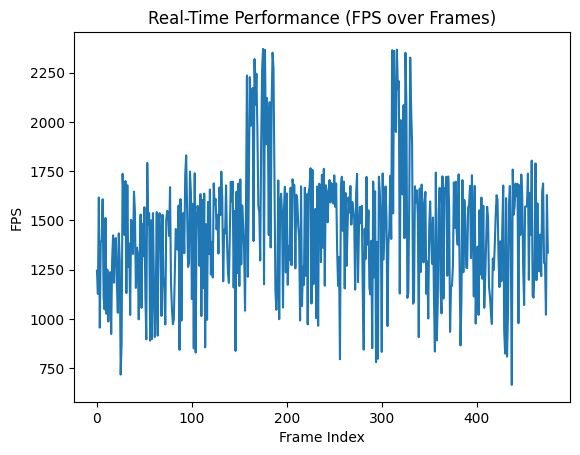

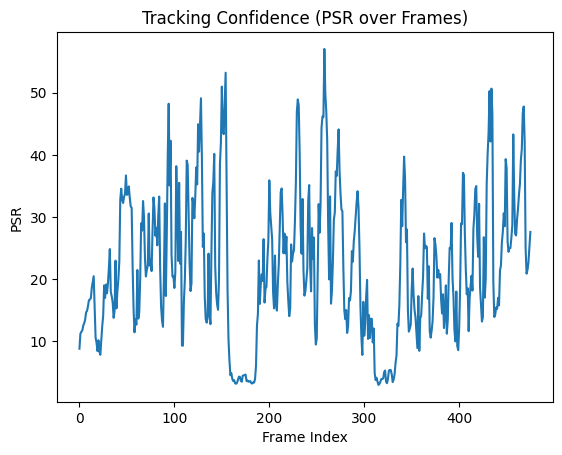

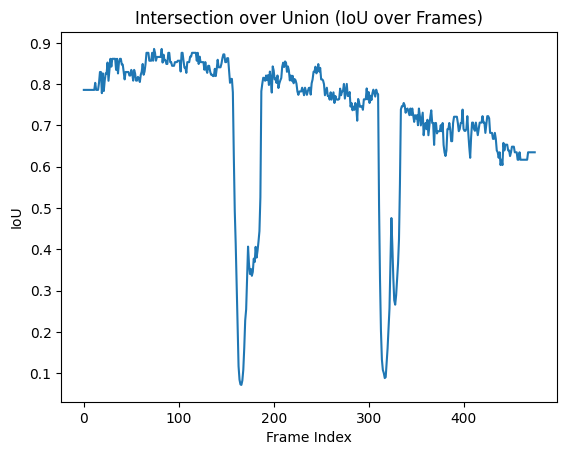

Tracking percentage (IoU):  89.91596638655463
Tracking percentage (PSR):  89.07563025210085


In [87]:
# Evaluate the same video with different parameters

learning_rate = 0.1
num_warps = 8
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")

## Evaluation Video 3: Human 6

Ground truth: (340, 358, 18, 55)


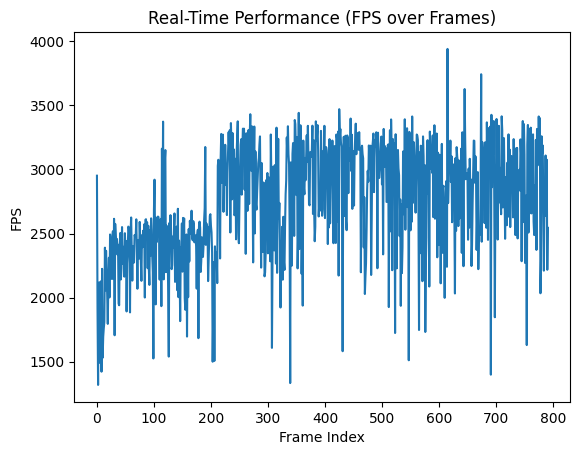

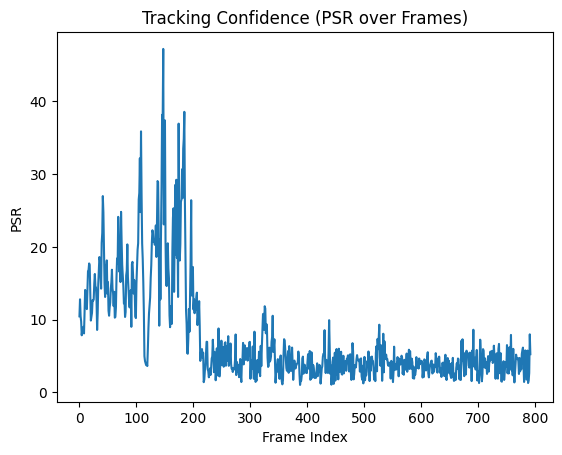

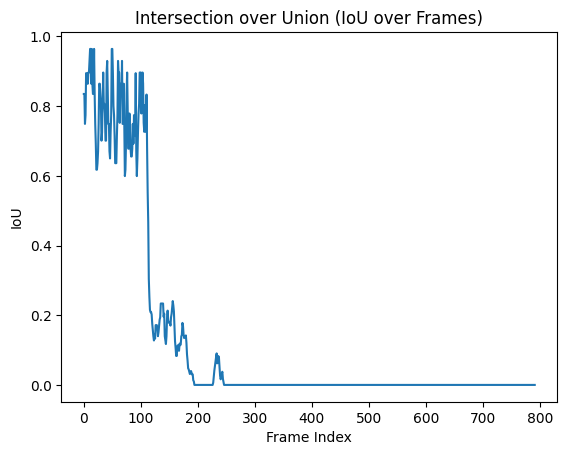

Tracking percentage (IoU):  14.267676767676768
Tracking percentage (PSR):  29.797979797979796


In [88]:
videos_dir = 'Media\\OTB'
video_1 = 'Human6'
video_dir = os.path.join(videos_dir, video_1)
frame_dir = os.path.join(video_dir, 'img')
frame_files = sorted(os.listdir(frame_dir))
frames = []
for frame in frame_files:
    image_path = os.path.join(frame_dir, frame)
    image = cv2.imread(image_path)
    frames.append(image)


'''
for frame in frames:
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()


roi_file = os.path.join(video_dir, 'groundtruth_rect.txt')
with open(roi_file, "r") as f:
    roi_str = f.readline()
roi = tuple(map(int, roi_str.split("\t")))
print("Selected ROI:", roi)
'''


learning_rate = 0.125
num_warps = 8
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")

Ground truth: (340, 358, 18, 55)


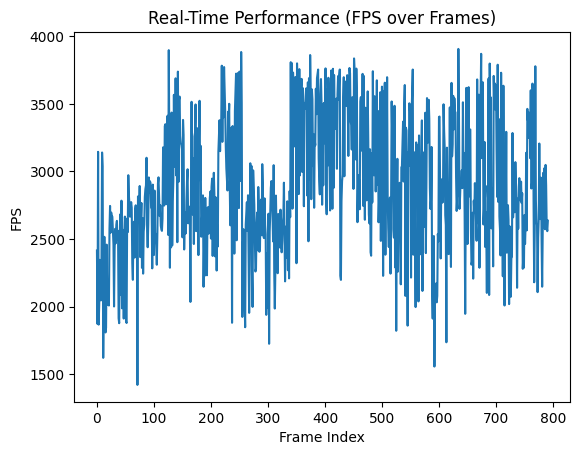

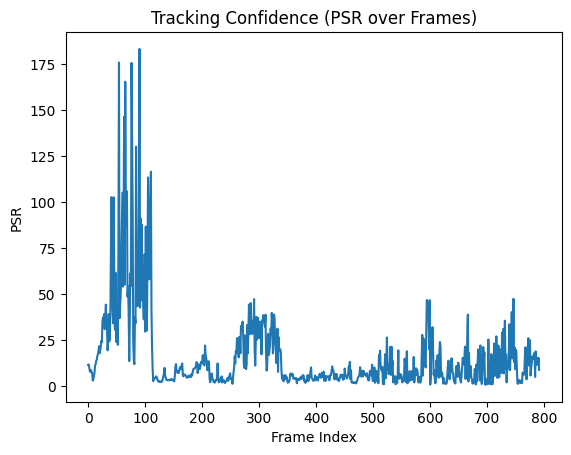

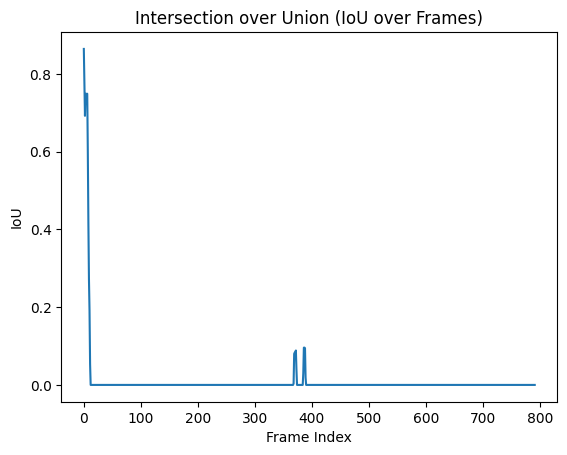

Tracking percentage (IoU):  1.0101010101010102
Tracking percentage (PSR):  54.04040404040404


In [68]:
# Evaluate the same video with different parameters

learning_rate = 0.125
num_warps = 8
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")

## Evaluation Video 4: Rubik

Ground truth: (276, 161, 73, 74)


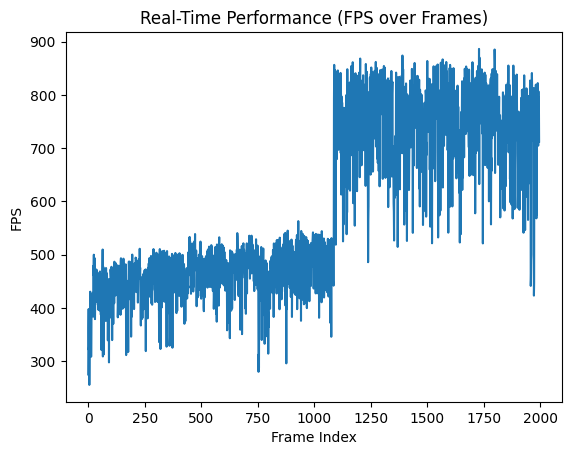

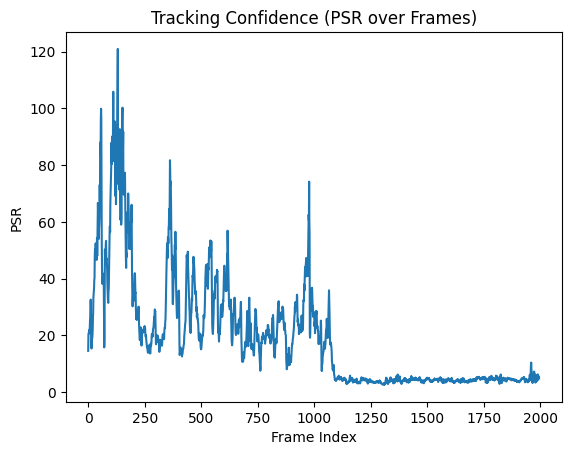

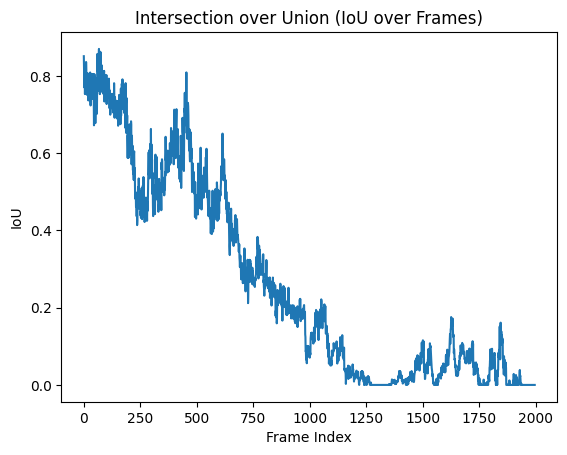

Tracking percentage (IoU):  24.18627941912869
Tracking percentage (PSR):  54.78217325988983


In [89]:
videos_dir = 'Media\\OTB'
video_1 = 'Rubik'
video_dir = os.path.join(videos_dir, video_1)
frame_dir = os.path.join(video_dir, 'img')
frame_files = sorted(os.listdir(frame_dir))
frames = []
for frame in frame_files:
    image_path = os.path.join(frame_dir, frame)
    image = cv2.imread(image_path)
    frames.append(image)


'''
for frame in frames:
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()


roi_file = os.path.join(video_dir, 'groundtruth_rect.txt')
with open(roi_file, "r") as f:
    roi_str = f.readline()
roi = tuple(map(int, roi_str.split("\t")))
print("Selected ROI:", roi)
'''


learning_rate = 0.125
num_warps = 8
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")

Ground truth: (276, 161, 73, 74)


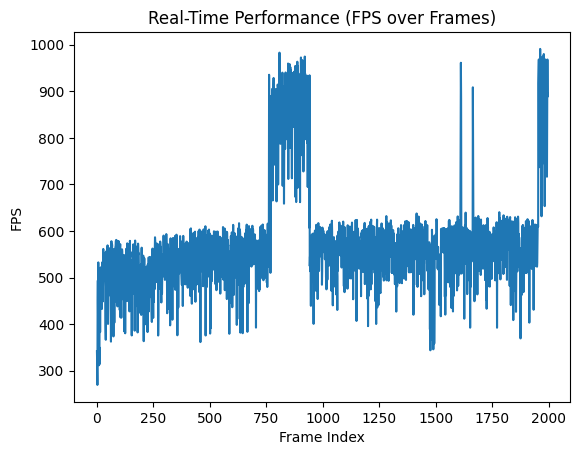

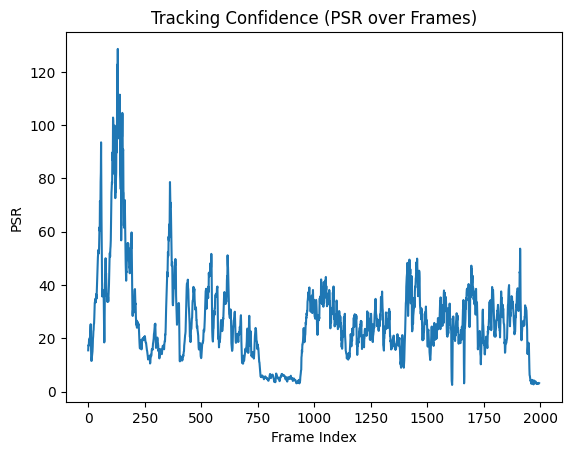

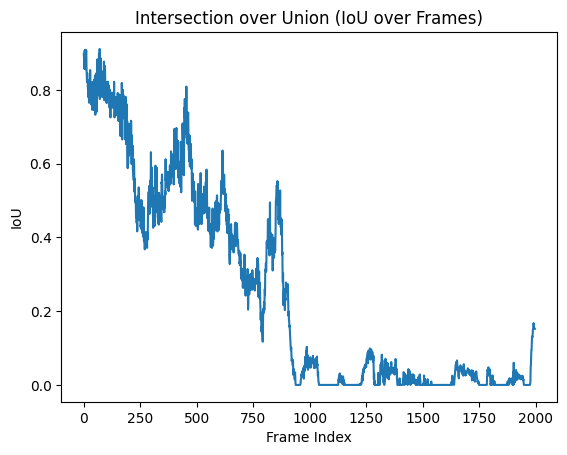

Tracking percentage (IoU):  22.43365047571357
Tracking percentage (PSR):  88.5327991987982


In [76]:
# Evaluate the same video different parameters


learning_rate = 0.1
num_warps = 8
psr_threshold = 7

ground_truth_list, roi_list = track_eval(video_dir, "images")